This notebook explores simple stuff you can do with patchscope

# Setup

In [1]:
%load_ext autoreload
%autoreload 3
import sys

sys.path.append("..")

In [2]:
from nnsight import LanguageModel, CONFIG
from nnsight.models.UnifiedTransformer import UnifiedTransformer
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch as th
import torch  # for those who are afraid of th
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
from pathlib import Path
from time import time
import itertools
from dataclasses import dataclass
from warnings import warn

th.set_grad_enabled(False)
import os

# os.environ["HF_TOKEN"] = "hf_token"
# CONFIG.set_default_api_key("nnsight")
dlabscratch = Path("/dlabscratch1/dlabscratch1/")
if not dlabscratch.exists():
    dlabscratch = dlabscratch.parent


@dataclass
class Config:
    remote: bool = False


config = Config()

# Utils

In [3]:
from IPython.display import Markdown, display


@dataclass
class Config:
    remote: bool = False
    max_batch_size: int = 64


config = Config()


def displaymd(string):
    display(
        Markdown(string.replace("<s>", "<‎s>"))
    )  # Little hack to prevent <s> from being interpreted as the html tag for strikethrough

In [4]:
from utils import plot_topk_tokens as plot_topk


def display_generations_md(nn_model, prompts, gen_strings: dict, replace_str=None):
    if isinstance(prompts, str):
        prompts = [prompts]
    md_strings = []

    def preprocess(s):
        if replace_str is not None:
            return s.replace(replace_str, "[[REPLACED]]")
        return s

    for i, prompt in enumerate(prompts):
        prompt = prompt.replace("\n", "\n\n")
        md_strings.append(f"**Prompt:** {prompt}")
        for k, v in gen_strings.items():
            gen = nn_model.tokenizer.decode(v[i])
            md_strings.append(
                f"- **Layer {k}:**<br>\n" + f"```\n{preprocess(gen)}\n```"
            )
        md_strings.append("\n")
    out = "\n".join(md_strings)
    displaymd(out)


def generations_to_table(nn_model, prompts, gen_strings: dict, replace_str=None):
    if isinstance(prompts, str):
        prompts = [prompts]
    df = pd.DataFrame({"Prompt": prompts})

    def preprocess(s):
        if replace_str is not None:
            return s.replace(replace_str, "[[REPLACED]]")
        return s

    dic = {
        f"Layer {k}": [preprocess(nn_model.tokenizer.decode(v)) for v in gen_strings[k]]
        for k in gen_strings
    }
    dflayer = pd.DataFrame(dic)
    df = pd.concat([df, dflayer], axis=1)
    df.style.hide(axis="index")
    return df


def display_generations_table(nn_model, prompts, gen_strings: dict, replace_str=None):
    df = generations_to_table(nn_model, prompts, gen_strings, replace_str)
    # fmt: off
    with pd.option_context(
        "display.max_colwidth", None,
        "display.max_columns", None,
        "display.max_rows", None,
    ):
        display(df)
    # fmt: on

# Patchscope & logit lens

In [5]:
from exp_tools import logit_lens

In [14]:
from exp_tools import patchscope_generate, patchscope_lens, TargetPrompt

# Prompt Utils

In [7]:
def identity_prompt(
    nn_model=None, words=None, rel=" ", sep="\n", placeholder="?"
) -> TargetPrompt:
    """
    Prompt used in the patchscopes paper to predict the next token.
    https://github.com/PAIR-code/interpretability/blob/master/patchscopes/code/next_token_prediction.ipynb
    """
    if words is None:
        words = ["cat", "1135", "hello"]
    assert nn_model is None or (
        len(nn_model.tokenizer.tokenize(placeholder)) == 1
    ), "Using a placeholder that is not a single token sounds like a bad idea"
    prompt = sep.join([w + rel + w for w in words]) + sep + placeholder
    index_to_patch = -1
    return TargetPrompt(prompt, index_to_patch)


def description_prompt(placeholder="?"):
    return TargetPrompt(
        f"""Jensen Huang is the CEO of NVIDIA, a technology company
New York City is the largest city in the United States
Johnny Depp is a famous actor known for his role in Pirates of the Caribbean
Google is a technology company known for its search engine
Ariana Grande is a famous singer from the United States
Sam Altman is the CEO of OpenAI, a research lab focused on artificial intelligence
The Eiffel Tower is a famous landmark in Paris, France
C++ is a programming language known for its speed and performance
A spoon is a utensil used for eating food
{placeholder}""",
        -1,
    )


example = identity_prompt()
displaymd(
    f"**Prompt:**\n```\n{example.prompt}\n```\n**Index to patch:** {example.index_to_patch}"
)

**Prompt:**
```
cat cat
1135 1135
hello hello
?
```
**Index to patch:** -1

# Playground

In [8]:
es_de_prompt = """Español: "rojo" - Deutsch: "rot"
Español: "mano" - Deutsch: "Hand"
Español: "grupo" - Deutsch: "Gruppe"
Español: "estrella" - Deutsch: "Stern"
Español: "puente" - Deutsch: "Brücke"
Español: "gato" - Deutsch: \""""
fr_en_prompt = """Français: "rouge" - English: "red"
Français: "main" - English: "hand"
Français: "groupe" - English: "group"
Français: "étoile" - English: "star"
Français: "pont" - English: "bridge"
Français: "chat" - English: \""""
es_fr_prompt = """Español: "rojo" - Français: "rouge"
Español: "mano" - Français: "main"
Español: "grupo" - Français: "groupe"
Español: "estrella" - Français: "étoile"
Español: "puente" - Français: "pont"
Español: "gato" - Français: \""""
de_zh_prompt = """Deutsch: "Fluss" - 中文: "河"
Deutsch: "Auge" - 中文: "眼睛"
Deutsch: "Meer" - 中文: "海"
Deutsch: "Person" - 中文: "现代人"
Deutsch: "Mutter" - 中文: "母親"
Deutsch: "Buch" - 中文: \""""
de_zh_prompt2 = """Deutsch: "Fluss" - 中文: "河"
Deutsch: "Auge" - 中文: "眼睛"
Deutsch: "Meer" - 中文: "海"
Deutsch: "Person" - 中文: "现代人"
Deutsch: "Buch" - 中文: "書"
Deutsch: "Mutter" - 中文: \""""

In [9]:
# llama_like = dlabscratch / "public/llm_weights/llama2_hf/Llama-2-7b-hf"
model = "croissantllm/croissantllmbase"
config.remote = False
model_path = model
# llama_like = dlabscratch / "public/llm_weights/llama3_hf/Meta-Llama-3-8B"
from utils import add_model_to_transformer_lens

add_model_to_transformer_lens(model)
hf_model = AutoModelForCausalLM.from_pretrained(
    model_path, device_map="cpu", torch_dtype=th.float16
)
nn_model = UnifiedTransformer(
    model,
    device="cuda",
    processing=False,
    gpus=th.cuda.device_count(),
    hf_model=hf_model,
    torch_dtype=th.float16,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model croissantllm/croissantllmbase into HookedTransformer


## Logit lens on the translations

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


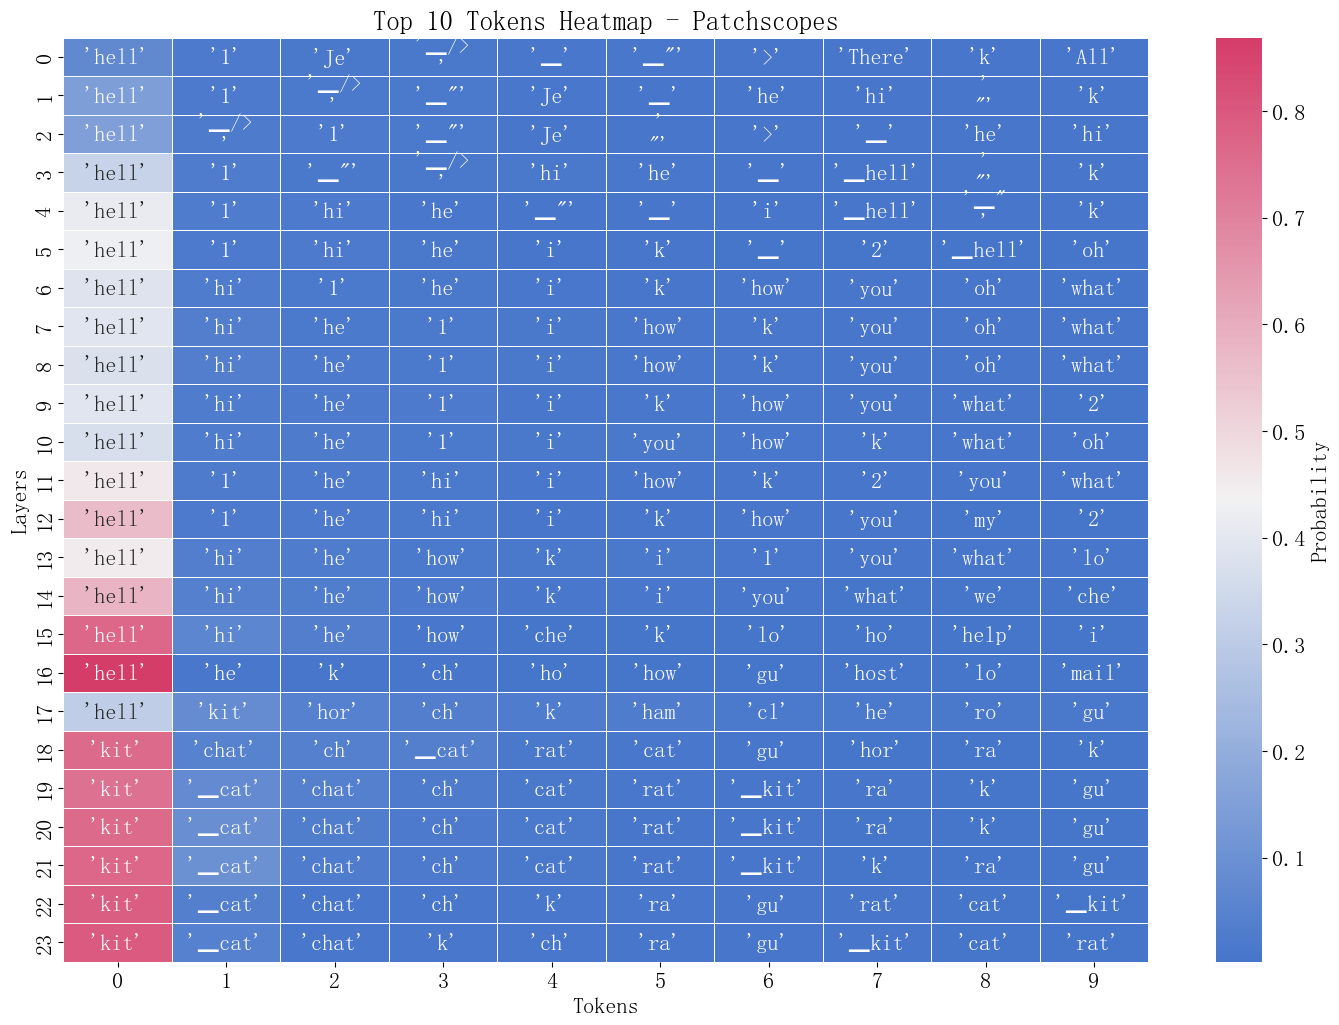

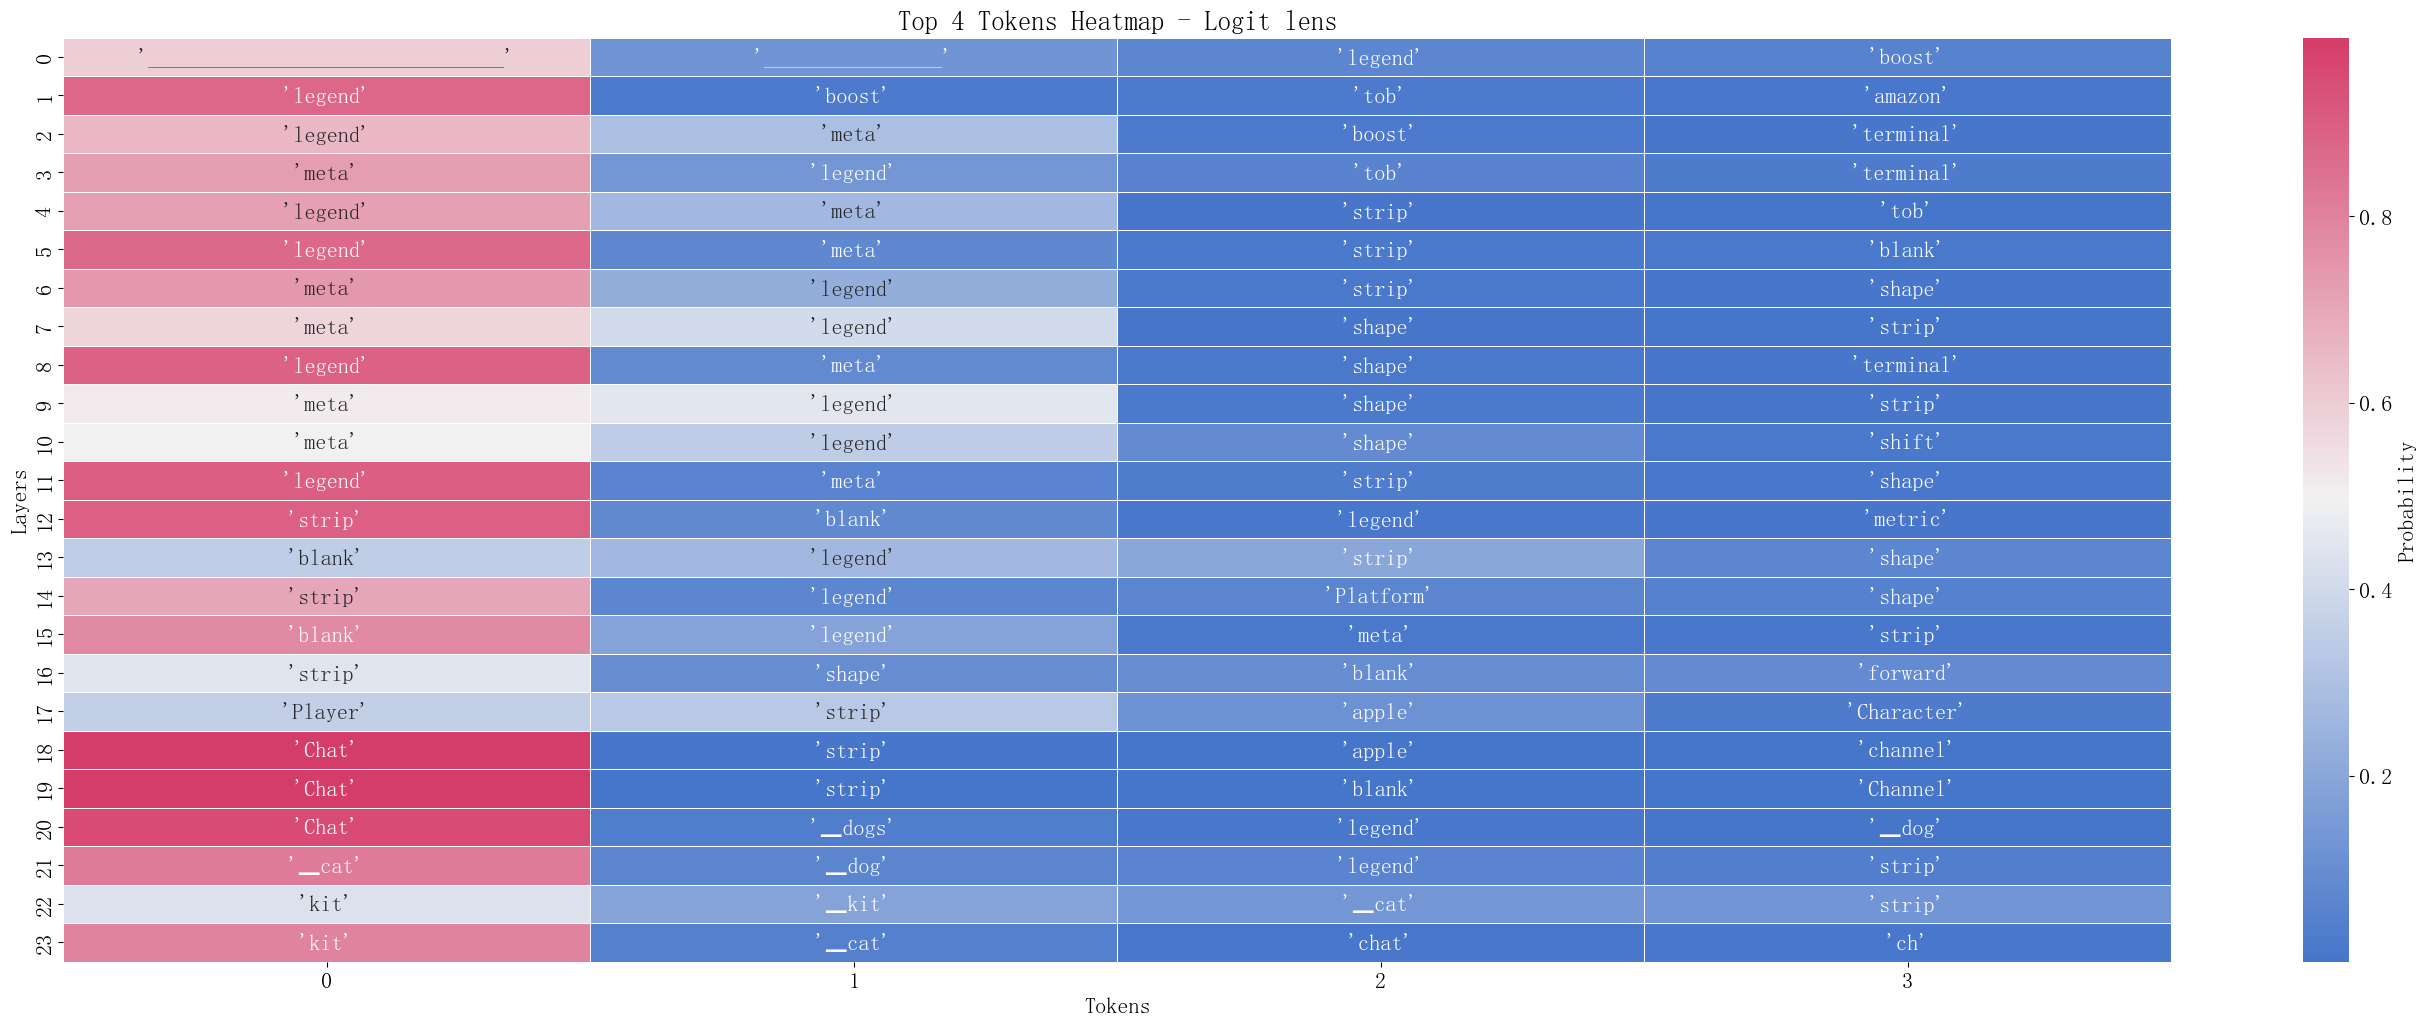

In [10]:
from exp_tools import patchscope_lens

probs = patchscope_lens(nn_model, fr_en_prompt)
plot_topk(probs[0], nn_model, k=10, title="Patchscopes")
ll_probs = logit_lens(nn_model, fr_en_prompt)
plot_topk(ll_probs[0], nn_model, k=4, title="Logit lens")

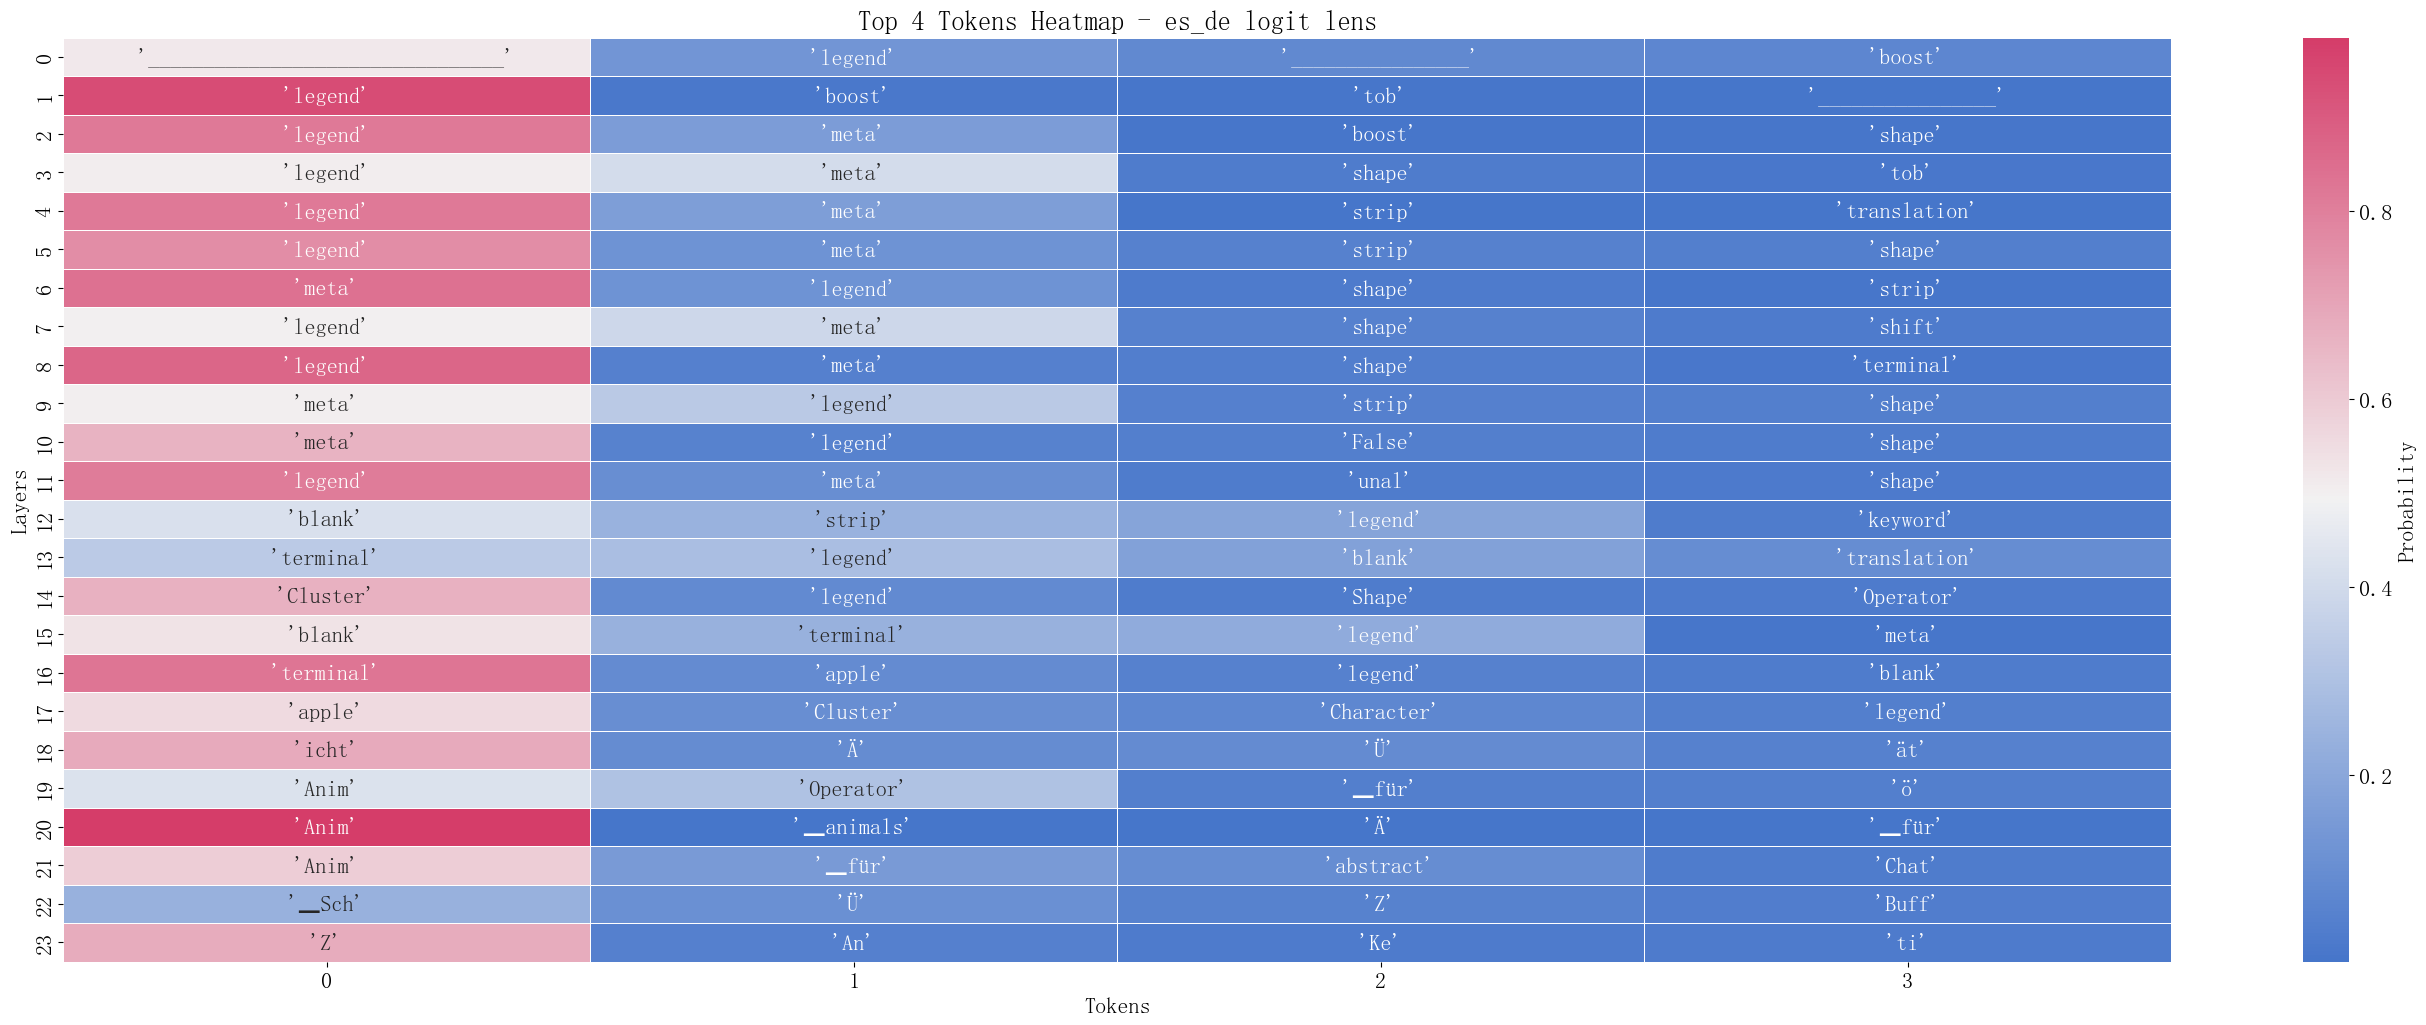

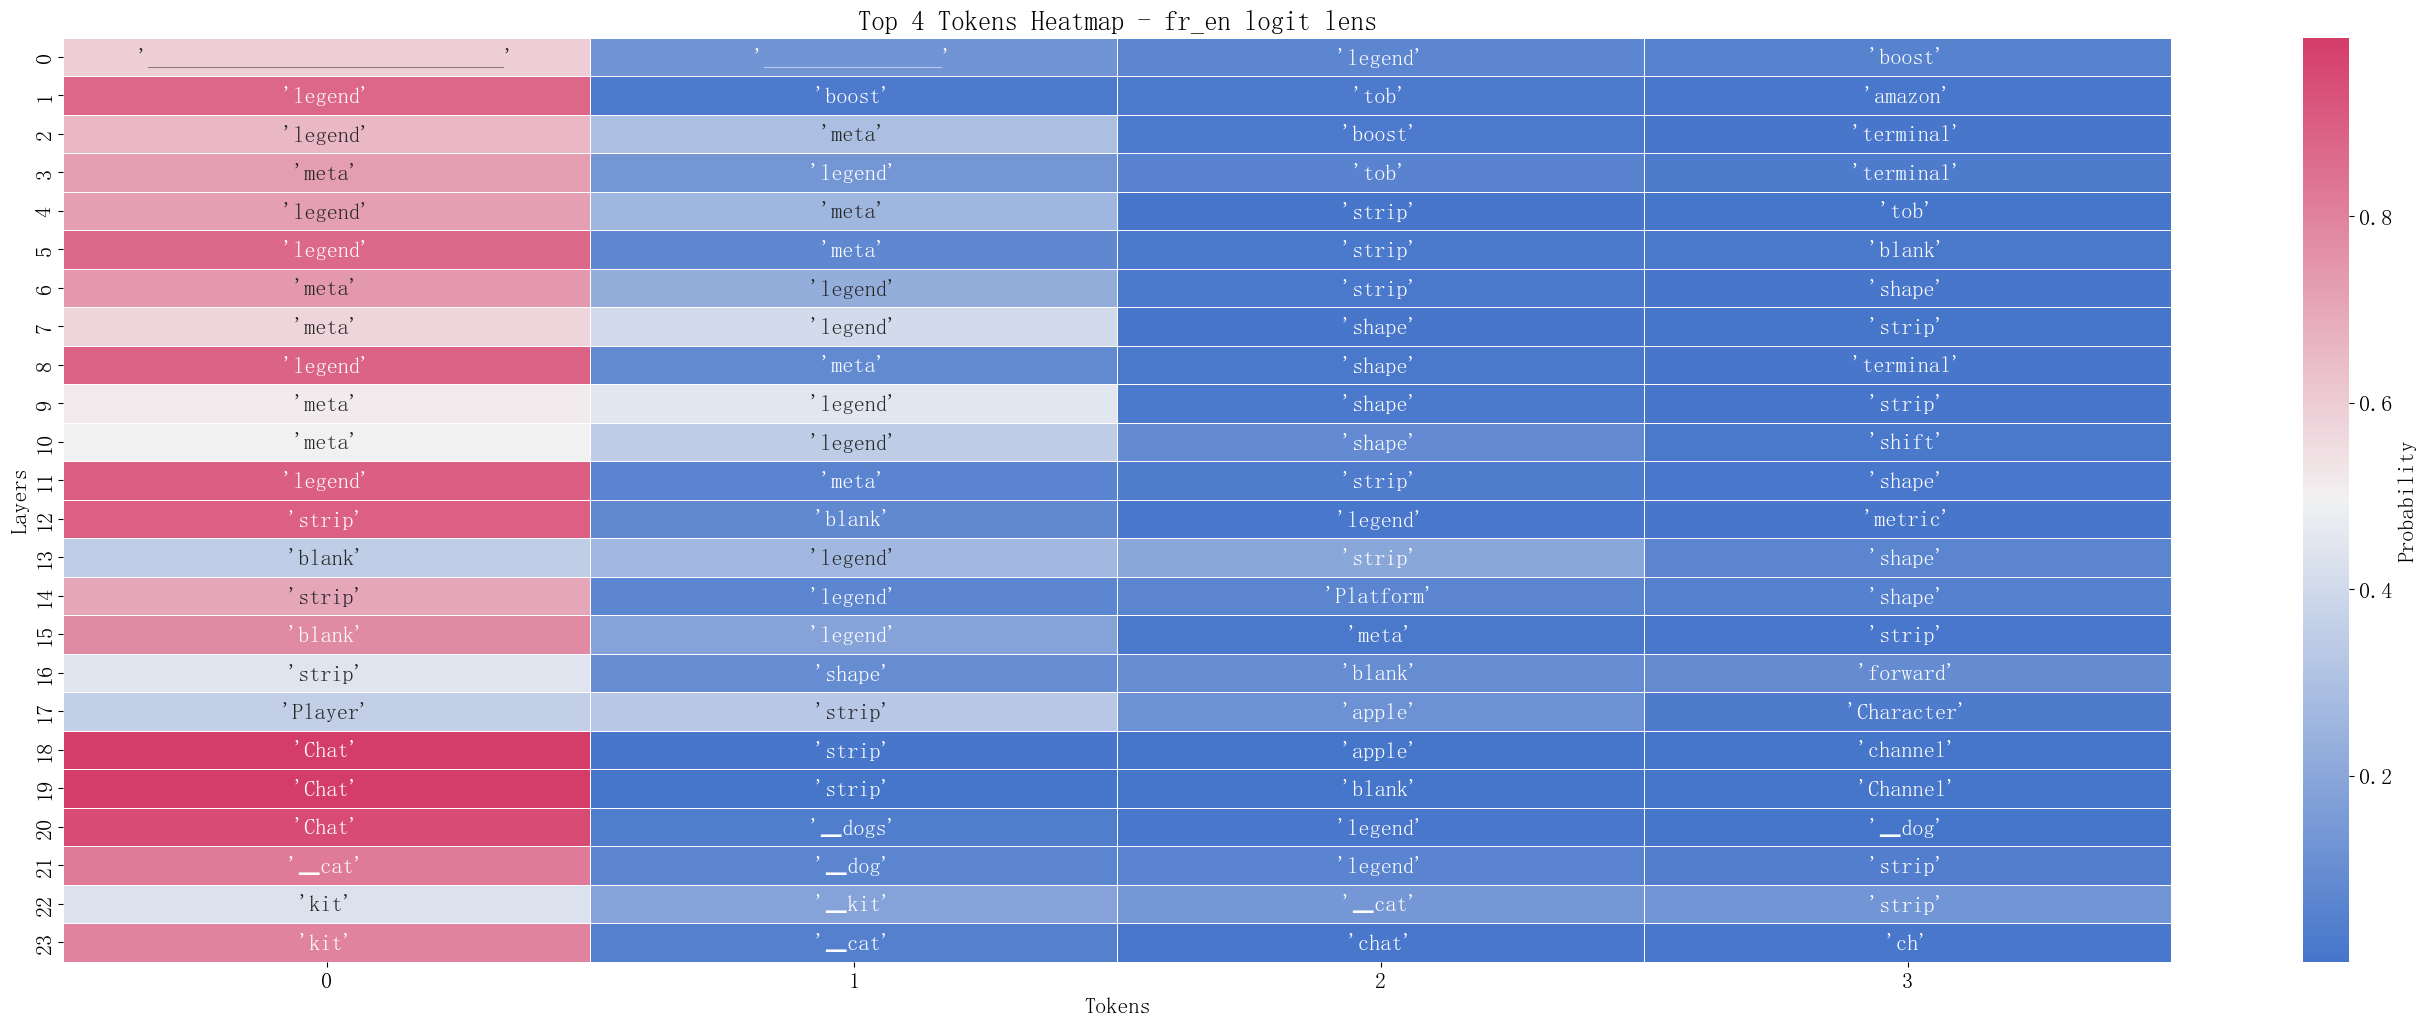

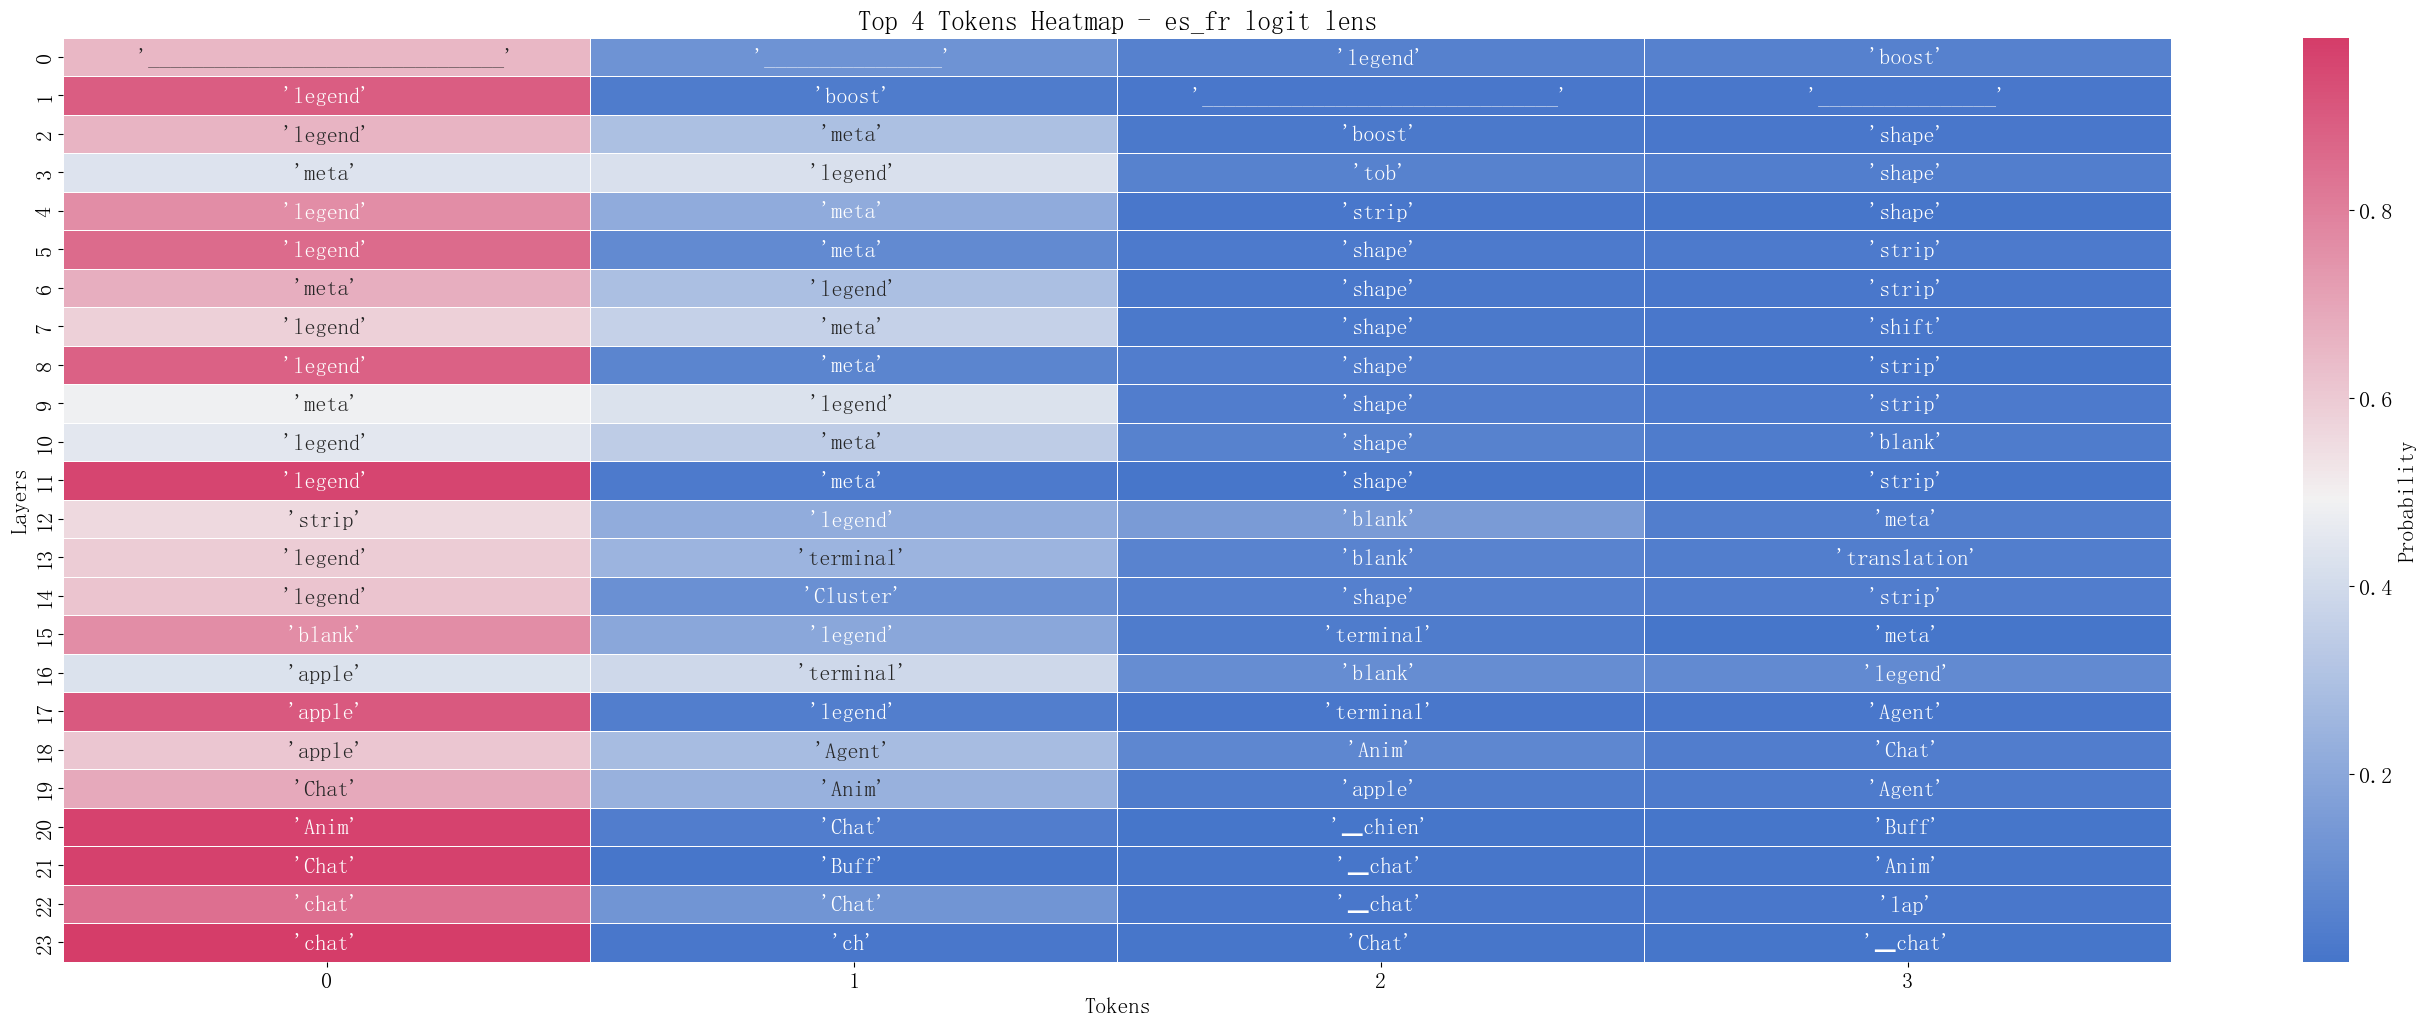

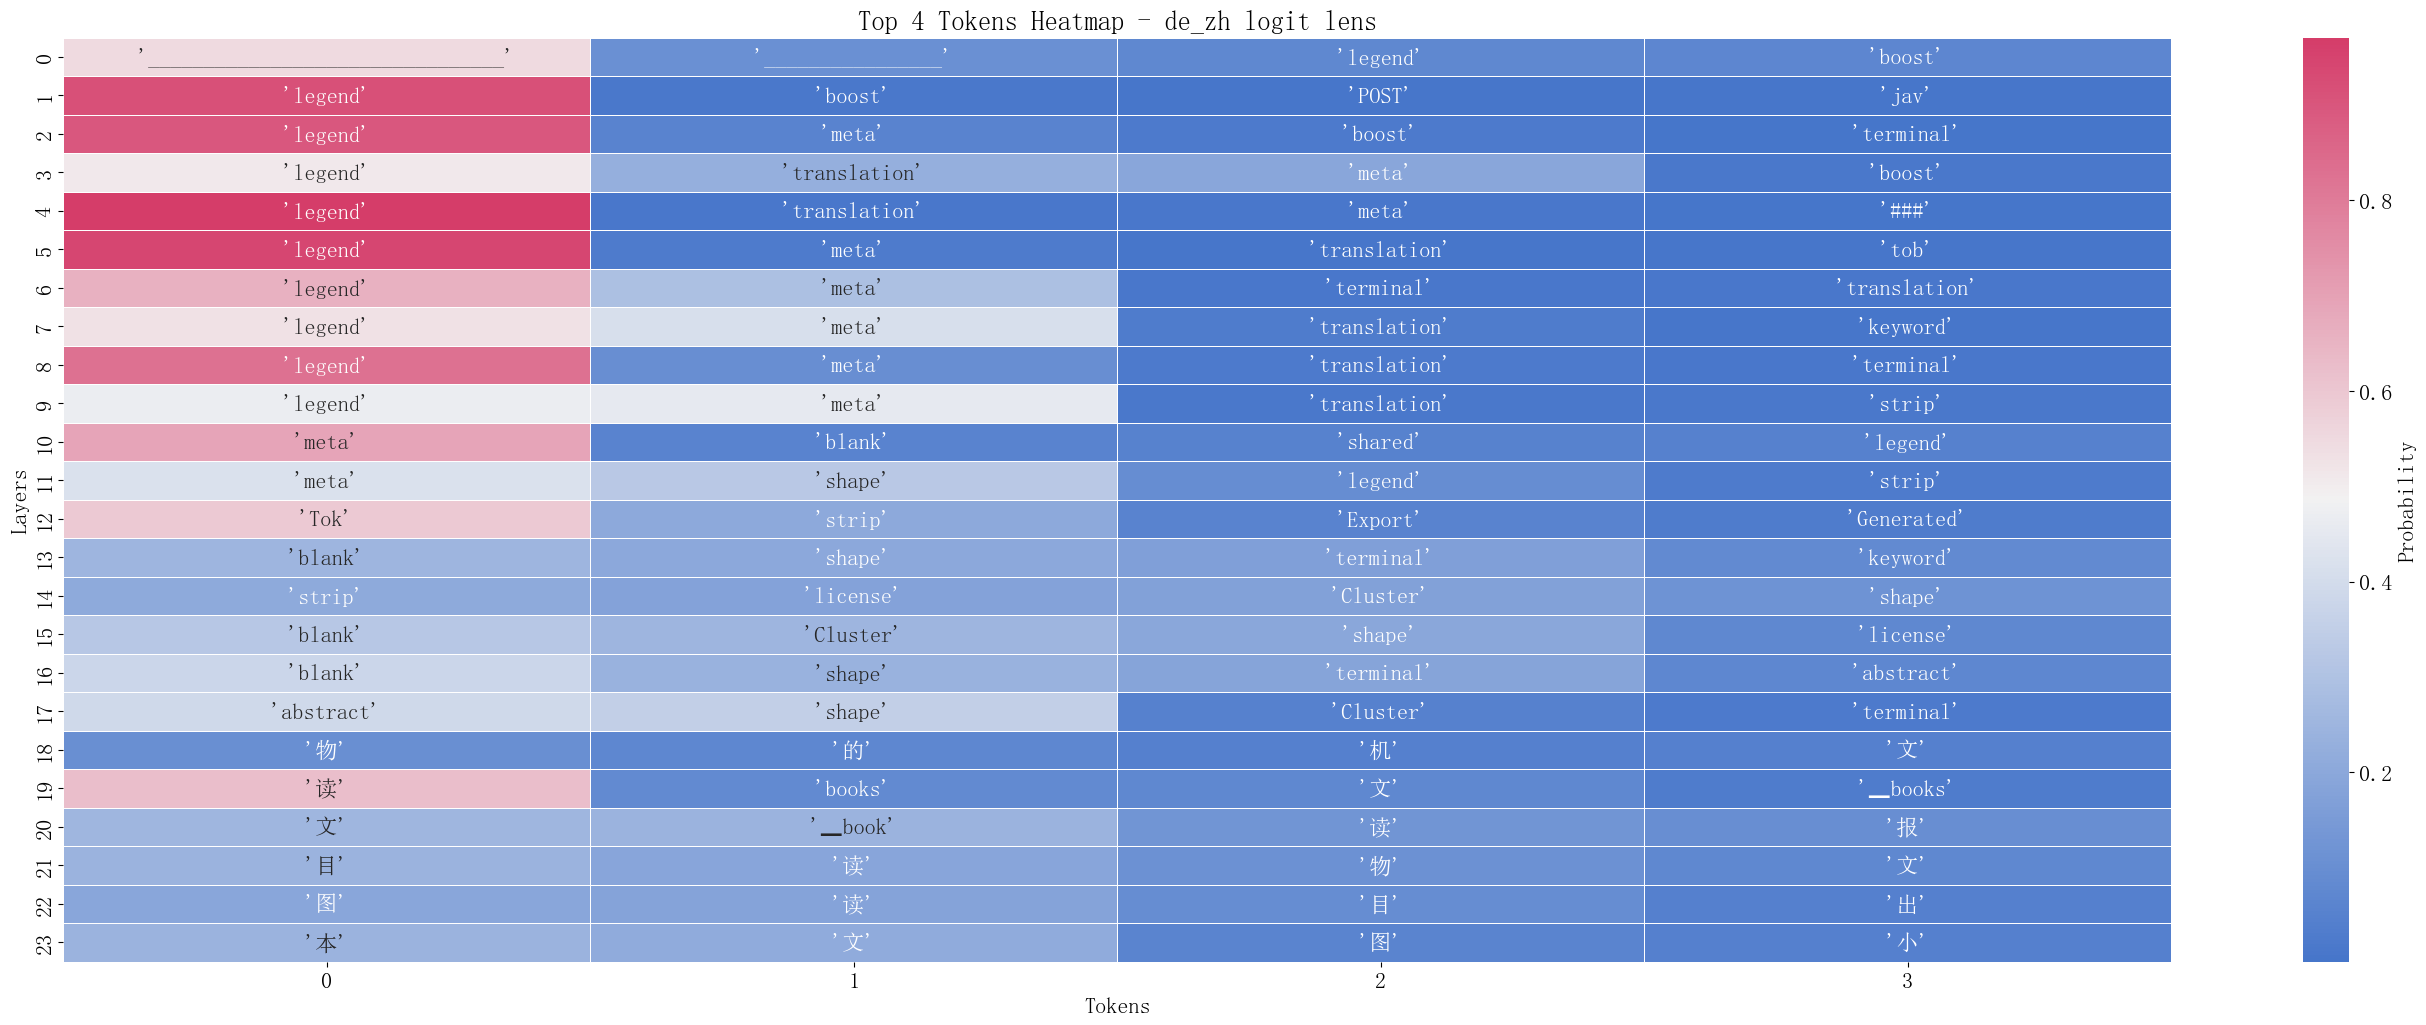

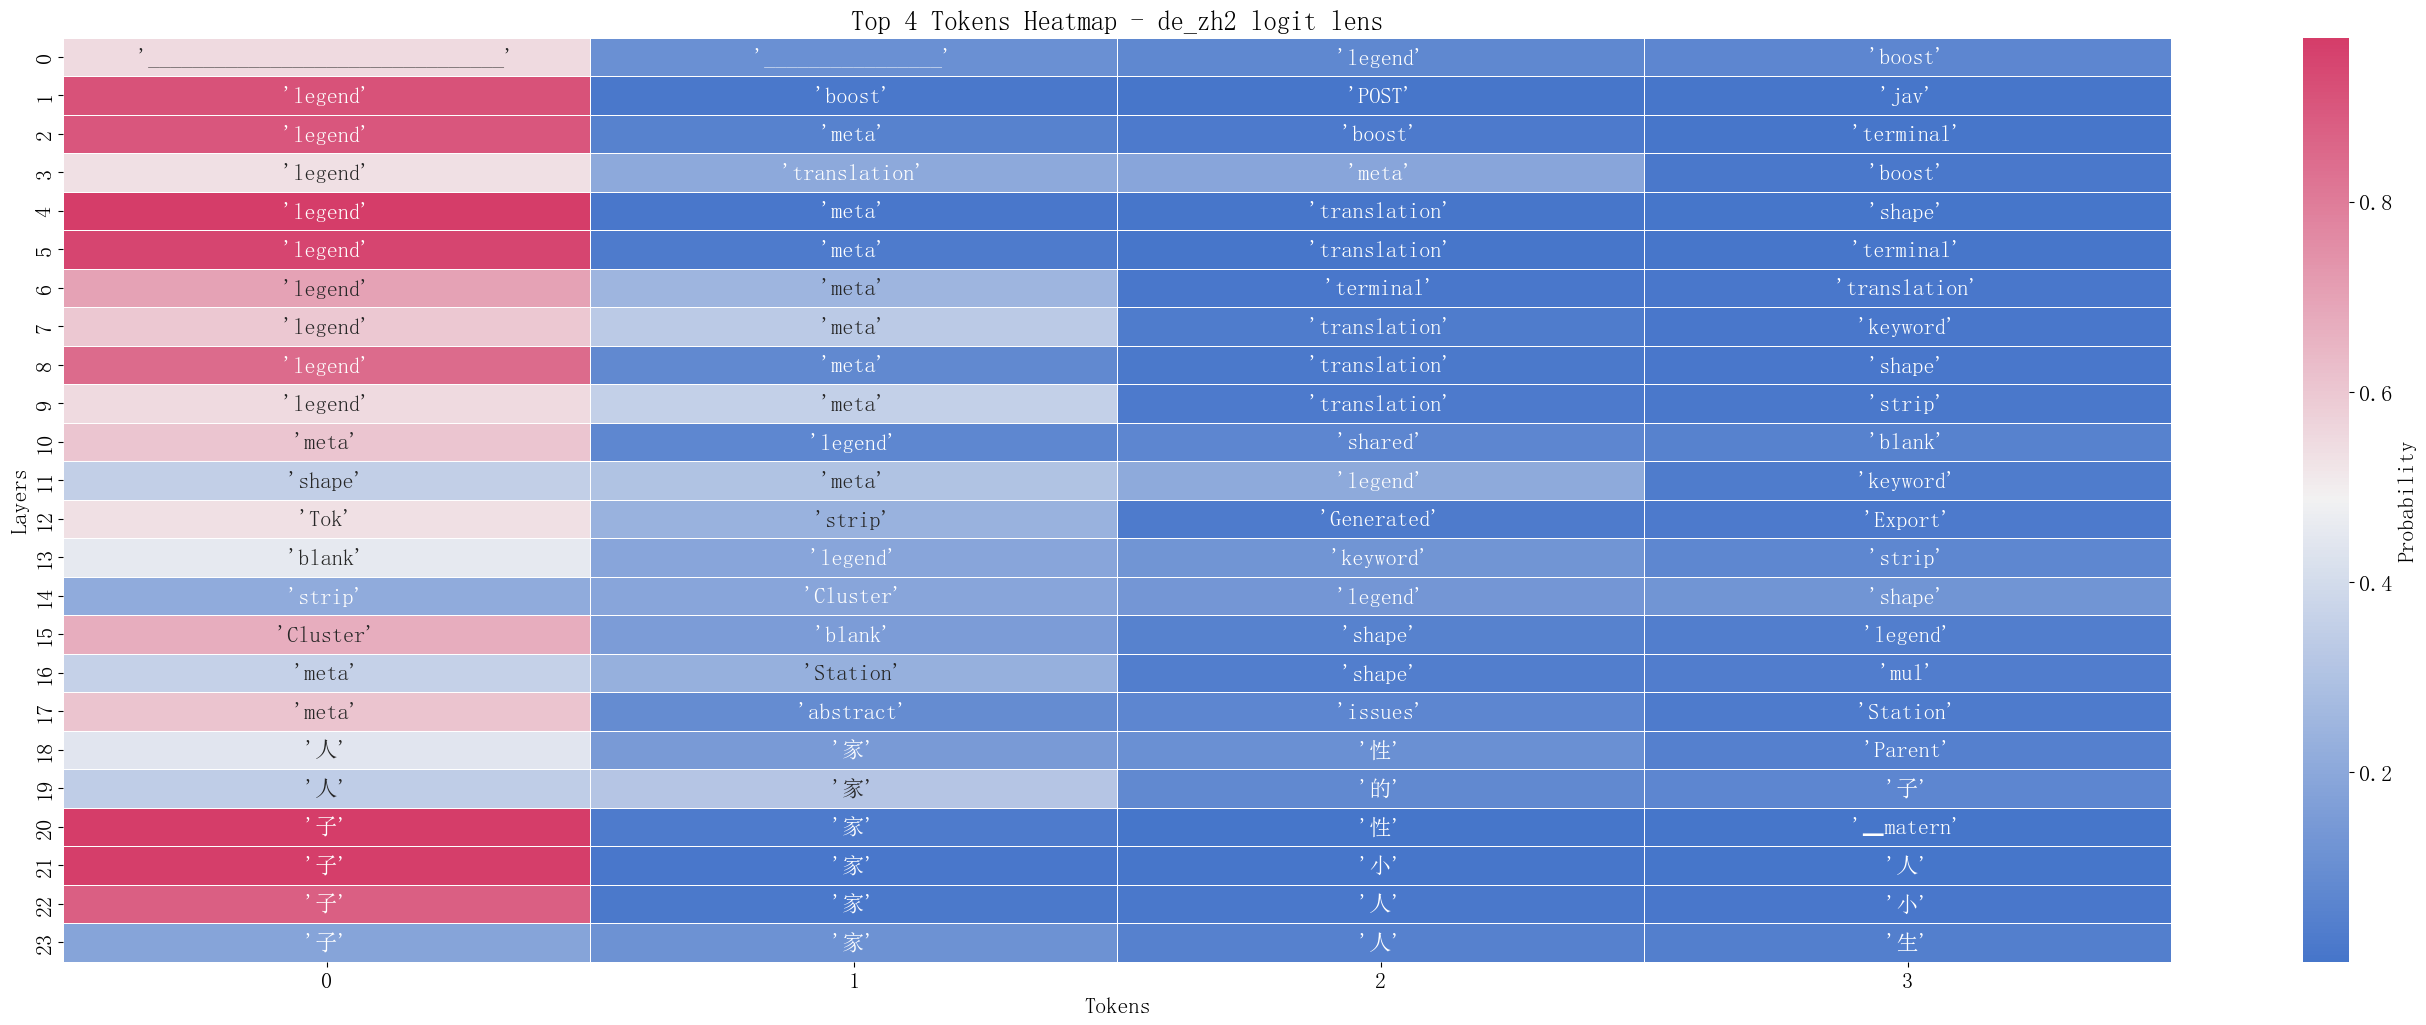

In [12]:
probs = logit_lens(
    nn_model, [es_de_prompt, fr_en_prompt, es_fr_prompt, de_zh_prompt, de_zh_prompt2]
)
plot_topk(probs[0], nn_model, k=4, title="es_de logit lens")
plot_topk(probs[1], nn_model, k=4, title="fr_en logit lens")
plot_topk(probs[2], nn_model, k=4, title="es_fr logit lens")
plot_topk(probs[3], nn_model, k=4, title="de_zh logit lens")
plot_topk(probs[4], nn_model, k=4, title="de_zh2 logit lens")

## Patchscoping

### Generation with repition task

In [19]:
patch_prompt = identity_prompt(nn_model)
patch_gen = patchscope_generate(
    nn_model, fr_en_prompt, patch_prompt, layers=[0, 5, 10, 15, 20]
)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [20]:
display_generations_table(nn_model, fr_en_prompt, patch_gen)

,Prompt,Layer 0,Layer 5,Layer 10,Layer 15,Layer 20
0,"Français: ""rouge"" - English: ""red""\nFrançais: ""main"" - English: ""hand""\nFrançais: ""groupe"" - English: ""group""\nFrançais: ""étoile"" - English: ""star""\nFrançais: ""pont"" - English: ""bridge""\nFrançais: ""chat"" - English: ""","<s> cat cat\n1135 1135\nhello hello\n?1135 1135""\nvoyeur voyeur\n2311 2311\nbar cheminée cheminée\n1212 1212\nmanette manette\n2859","<s> cat cat\n1135 1135\nhello hello\n?what's that""\nhello hello\nUNITED STATES United States\nLa Français Cup\nÉpreuve à Calabasas (États-Unis)\nDiffusée le 17/07/2017\nA Los Angeles est diffusée","<s> cat cat\n1135 1135\nhello hello\n?hello hello""\t', '/ms/dbplug/1135/log/plugins/fa/ea/cadf/log/plugins"",8221405L, \\n""endCodec roleRegister502","<s> cat cat\n1135 1135\nhello hello\n?hello hello\n\n553 553\n\nNumber 13 equals this answer. :-)\n\n\nFun fact-\nUsing tally-Wingiend as your answer test, I have discovered a new case of limits respecting max and m",<s> cat cat\n1135 1135\nhello hello\n?kitty\n 1135 1135 343535 353434\n0 0 0 0 0 1944 0 0 \n6.3


In [21]:
display_generations_md(nn_model, fr_en_prompt, patch_gen)

**Prompt:** Français: "rouge" - English: "red"

Français: "main" - English: "hand"

Français: "groupe" - English: "group"

Français: "étoile" - English: "star"

Français: "pont" - English: "bridge"

Français: "chat" - English: "
- **Layer 0:**<br>
```
<‎s> cat cat
1135 1135
hello hello
?1135 1135"
voyeur voyeur
2311 2311
bar cheminée cheminée
1212 1212
manette manette
2859
```
- **Layer 5:**<br>
```
<‎s> cat cat
1135 1135
hello hello
?what's that"
hello hello
UNITED STATES United States
La Français Cup
Épreuve à Calabasas (États-Unis)
Diffusée le 17/07/2017
A Los Angeles est diffusée
```
- **Layer 10:**<br>
```
<‎s> cat cat
1135 1135
hello hello
?hello hello"	', '/ms/dbplug/1135/log/plugins/fa/ea/cadf/log/plugins",8221405L, \
"endCodec roleRegister502
```
- **Layer 15:**<br>
```
<‎s> cat cat
1135 1135
hello hello
?hello hello

553 553

Number 13 equals this answer. :-)


Fun fact-
Using tally-Wingiend as your answer test, I have discovered a new case of limits respecting max and m
```
- **Layer 20:**<br>
```
<‎s> cat cat
1135 1135
hello hello
?kitty
 1135 1135 343535 353434
0 0 0 0 0 1944 0 0 
6.3
```



### Generation with description task

In [24]:
from utils import StopOnTokens

patch_prompt = description_prompt()
# jeff = "This is an interview with the CEO of Amazon"
jeff = "Jeff Bezos"
stopping_criteria = StopOnTokens.from_string("\n", nn_model.tokenizer)
patch_gen = patchscope_generate(
    nn_model, jeff, patch_prompt, stop_tokens=stopping_criteria.stop_tokens
)
display_generations_table(
    nn_model, jeff, patch_gen, replace_str=patch_prompt.prompt[:-2]
)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

,Prompt,Layer 0,Layer 1,Layer 2,Layer 3,Layer 4,Layer 5,Layer 6,Layer 7,Layer 8,Layer 9,Layer 10,Layer 11,Layer 12,Layer 13,Layer 14,Layer 15,Layer 16,Layer 17,Layer 18,Layer 19,Layer 20,Layer 21,Layer 22,Layer 23
0,Jeff Bezos,<s> [[REPLACED]]\n?teoporosis is a deformity of the bones associated with fragility and loss of\nW</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>,<s> [[REPLACED]]\n? spacecraft\n</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>,<s> [[REPLACED]]\n?mug that contains a cup of coffee spoon cup of coffee wine pot coffee mug receiving a cup of coffee roaster in a coffee shop eating baguette salt baguette tap condiments on a plate red wine chocolate cheese thisIl,<s> [[REPLACED]]\n?moshtaqTwitch\nK</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>,<s> [[REPLACED]]\n?mui is a picker in React\nA</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>,<s> [[REPLACED]]\n? A B C D E F G H I J K L M N O P Q R S T U V W X Y Z\nCopyright</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>,<s> [[REPLACED]]\n?pace and decisindpm will be added sometime in '18\nThe</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>,<s> [[REPLACED]]\n? is the founder and owner of the beverage company Amazon\nIn</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>,<s> [[REPLACED]]\n? was a billionaire who made his fortune from selling Amazon\nThe</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>,"<s> [[REPLACED]]\n? is the founder of public records and files in Queens, Queens, NY\nF</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>",<s> [[REPLACED]]\n? is Amazon's founder responsible for many different types of physical retail stores\nAr</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>,<s> [[REPLACED]]\n? (by a popular vote)\nL</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>,<s> [[REPLACED]]\n? is a person known for his reputation as an investor and businessman\nF</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>,<s> [[REPLACED]]\n? is the biggest person in business and founded Amazon\nD</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>,<s> [[REPLACED]]\n? is a lower-case letter in English and Latin alphabet\nJ</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>,<s> [[REPLACED]]\n? was added to the United States Flag Code on 25 July 1947 in the United States Senate by Sen. George Washington\nC</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>,<s> [[REPLACED]]\n? begins with A\nA</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>,"<s> [

In [25]:
from utils import StopOnTokens

patch_prompt = description_prompt()
# jeff = "This is an interview with the CEO of Amazon"
jeff = "Jeff Bezos"
stopping_criteria = StopOnTokens.from_string("\n", nn_model.tokenizer)
patch_gen2 = patchscope_generate(
    nn_model, jeff, patch_prompt, stop_tokens=stopping_criteria.stop_tokens
)
display_generations_table(
    nn_model, jeff, patch_gen, replace_str=patch_prompt.prompt[:-2]
)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

,Prompt,Layer 0,Layer 1,Layer 2,Layer 3,Layer 4,Layer 5,Layer 6,Layer 7,Layer 8,Layer 9,Layer 10,Layer 11,Layer 12,Layer 13,Layer 14,Layer 15,Layer 16,Layer 17,Layer 18,Layer 19,Layer 20,Layer 21,Layer 22,Layer 23
0,Jeff Bezos,<s> [[REPLACED]]\n?teoporosis is a deformity of the bones associated with fragility and loss of\nW</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>,<s> [[REPLACED]]\n? spacecraft\n</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>,<s> [[REPLACED]]\n?mug that contains a cup of coffee spoon cup of coffee wine pot coffee mug receiving a cup of coffee roaster in a coffee shop eating baguette salt baguette tap condiments on a plate red wine chocolate cheese thisIl,<s> [[REPLACED]]\n?moshtaqTwitch\nK</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>,<s> [[REPLACED]]\n?mui is a picker in React\nA</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>,<s> [[REPLACED]]\n? A B C D E F G H I J K L M N O P Q R S T U V W X Y Z\nCopyright</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>,<s> [[REPLACED]]\n?pace and decisindpm will be added sometime in '18\nThe</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>,<s> [[REPLACED]]\n? is the founder and owner of the beverage company Amazon\nIn</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>,<s> [[REPLACED]]\n? was a billionaire who made his fortune from selling Amazon\nThe</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>,"<s> [[REPLACED]]\n? is the founder of public records and files in Queens, Queens, NY\nF</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>",<s> [[REPLACED]]\n? is Amazon's founder responsible for many different types of physical retail stores\nAr</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>,<s> [[REPLACED]]\n? (by a popular vote)\nL</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>,<s> [[REPLACED]]\n? is a person known for his reputation as an investor and businessman\nF</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>,<s> [[REPLACED]]\n? is the biggest person in business and founded Amazon\nD</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>,<s> [[REPLACED]]\n? is a lower-case letter in English and Latin alphabet\nJ</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>,<s> [[REPLACED]]\n? was added to the United States Flag Code on 25 July 1947 in the United States Senate by Sen. George Washington\nC</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>,<s> [[REPLACED]]\n? begins with A\nA</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>,"<s> [

TargetPrompt(prompt='cat cat\n1135 1135\nhello hello\n?', index_to_patch=-1)


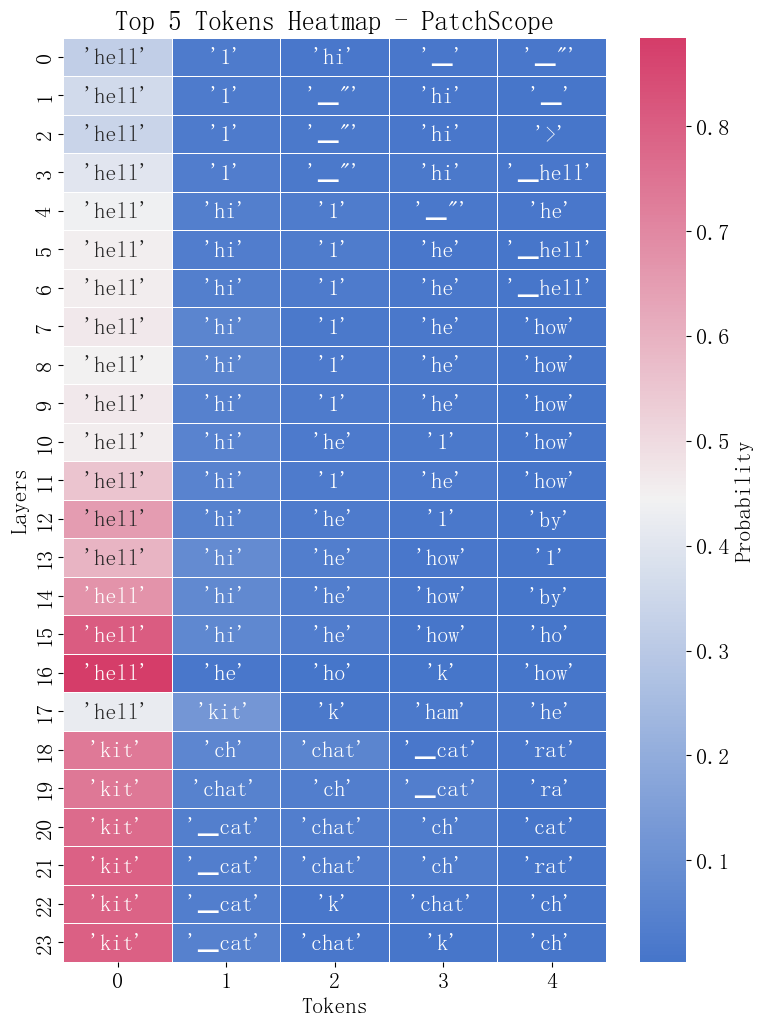

In [26]:
patch_prompt = identity_prompt(nn_model)
print(patch_prompt)
patch_probs = patchscope_lens(nn_model, fr_en_prompt, patch_prompt, remote=False)
plot_topk(patch_probs[0], nn_model, k=5, title="PatchScope")

TargetPrompt(prompt='cat cat\n1135 1135\nhello hello\n', index_to_patch=-1)


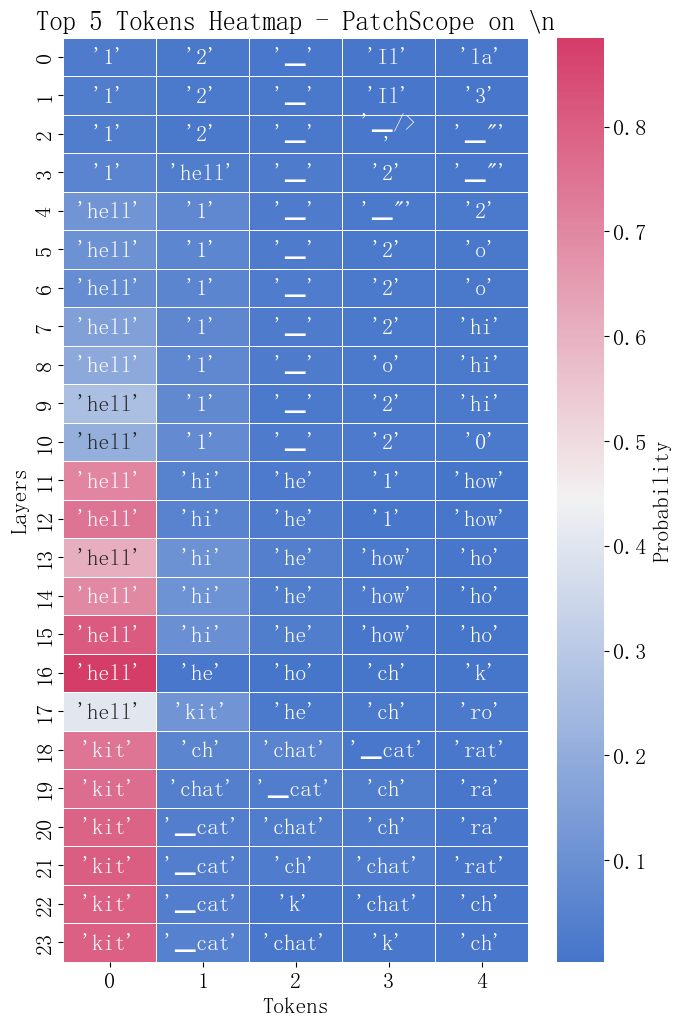

In [27]:
patch_prompt = identity_prompt(nn_model)
patch_prompt.prompt = patch_prompt.prompt[:-1]
print(patch_prompt)
patch_probs = patchscope_lens(nn_model, fr_en_prompt, patch_prompt, remote=False)
plot_topk(patch_probs[0], nn_model, k=5, title="PatchScope on \\n")

TargetPrompt(prompt='cat cat\n1135 1135\nhello hello\n? ->', index_to_patch=-2)


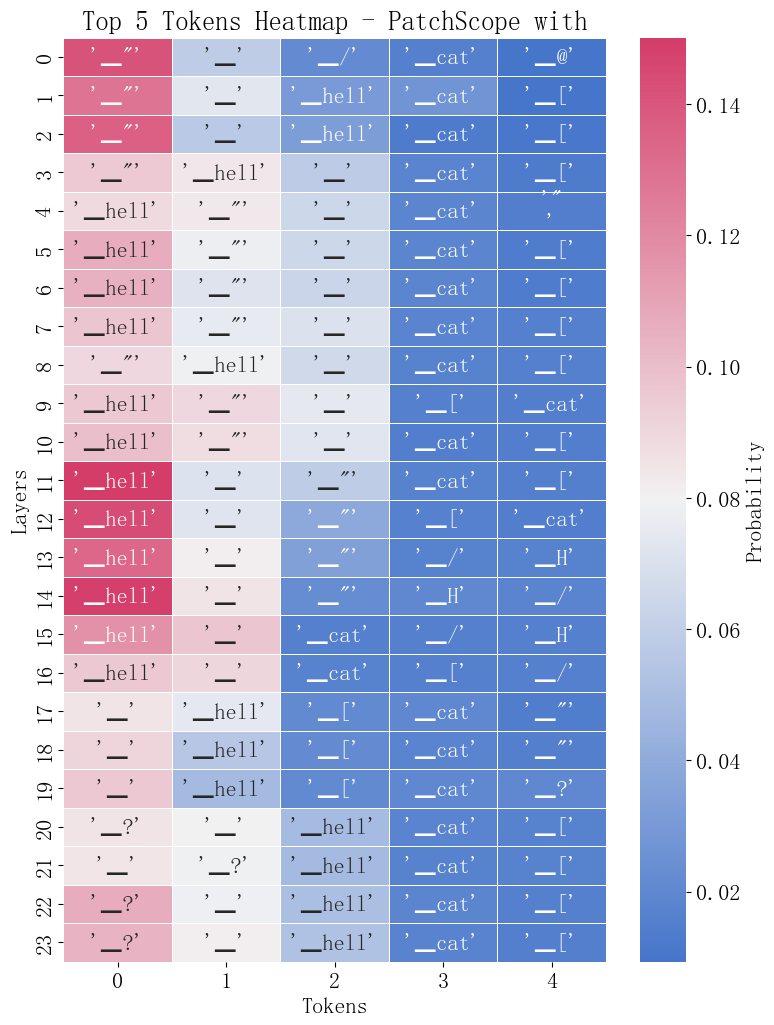

In [28]:
patch_prompt = identity_prompt(nn_model)
patch_prompt.prompt = patch_prompt.prompt + " ->"
patch_prompt.index_to_patch = -len(nn_model.tokenizer.tokenize(" ->")) - 1
print(patch_prompt)
patch_probs = patchscope_lens(nn_model, fr_en_prompt, patch_prompt, remote=False)
plot_topk(patch_probs[0], nn_model, k=5, title="PatchScope with")

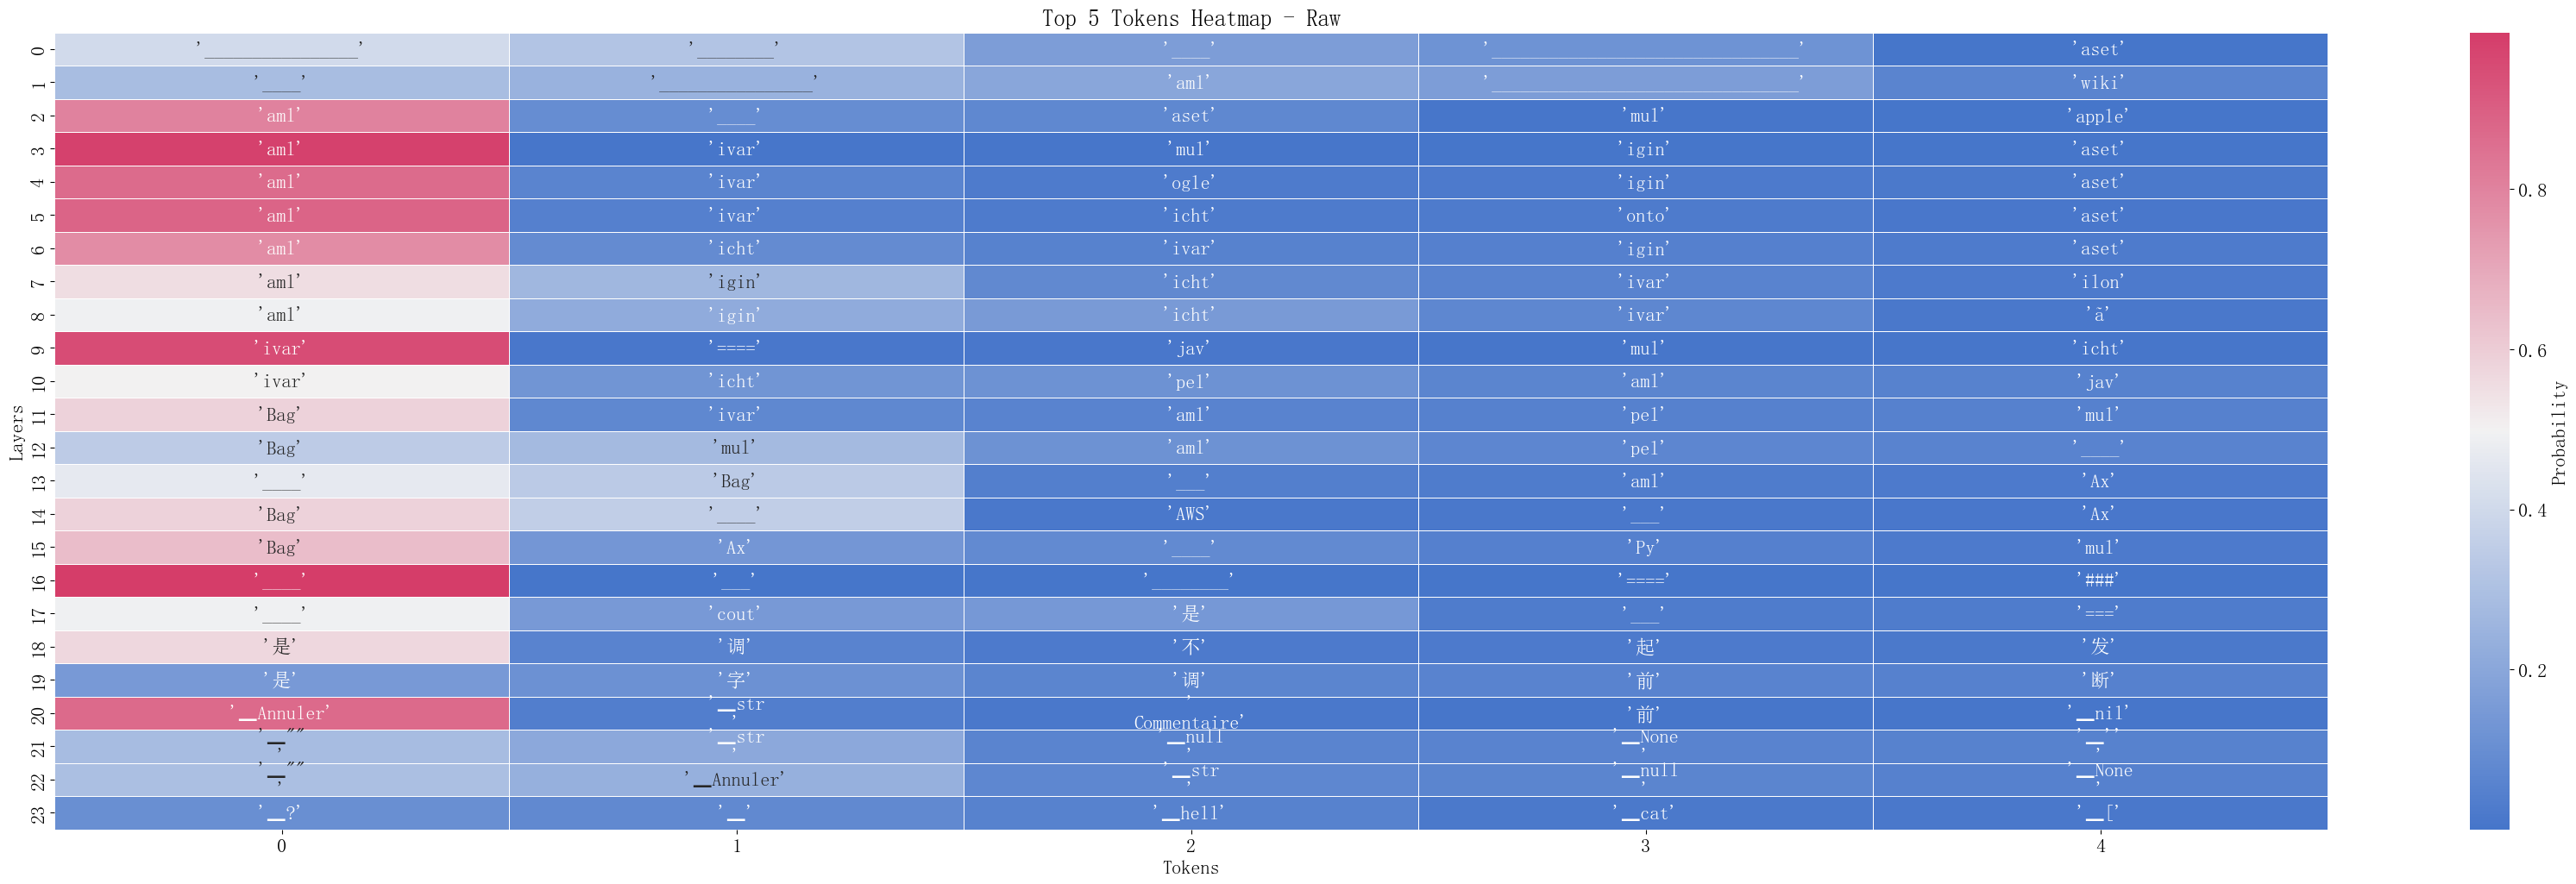

In [29]:
raw_probs = logit_lens(nn_model, patch_prompt.prompt)
plot_topk(raw_probs[0], nn_model, k=5, title="Raw")

In [30]:
empty_prompt = identity_prompt(nn_model, sep="", words=[], rel="")
print(f"empty prompt : {empty_prompt}")
empty_probs = patchscope_lens(nn_model, fr_en_prompt, empty_prompt, remote=False)
patch_prompt = identity_prompt(nn_model)
patch_prompt.prompt = patch_prompt.prompt[:-1]
patch_prompt.index_to_patch = -1
print(f"patch prompt : {patch_prompt}")
patch_probs = patchscope_lens(nn_model, fr_en_prompt, patch_prompt, remote=False)
llens_probs = logit_lens(nn_model, fr_en_prompt)

empty prompt : TargetPrompt(prompt='?', index_to_patch=-1)
patch prompt : TargetPrompt(prompt='cat cat\n1135 1135\nhello hello\n', index_to_patch=-1)


/dlabscratch1/cdumas/.conda_envs/llmenglish/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


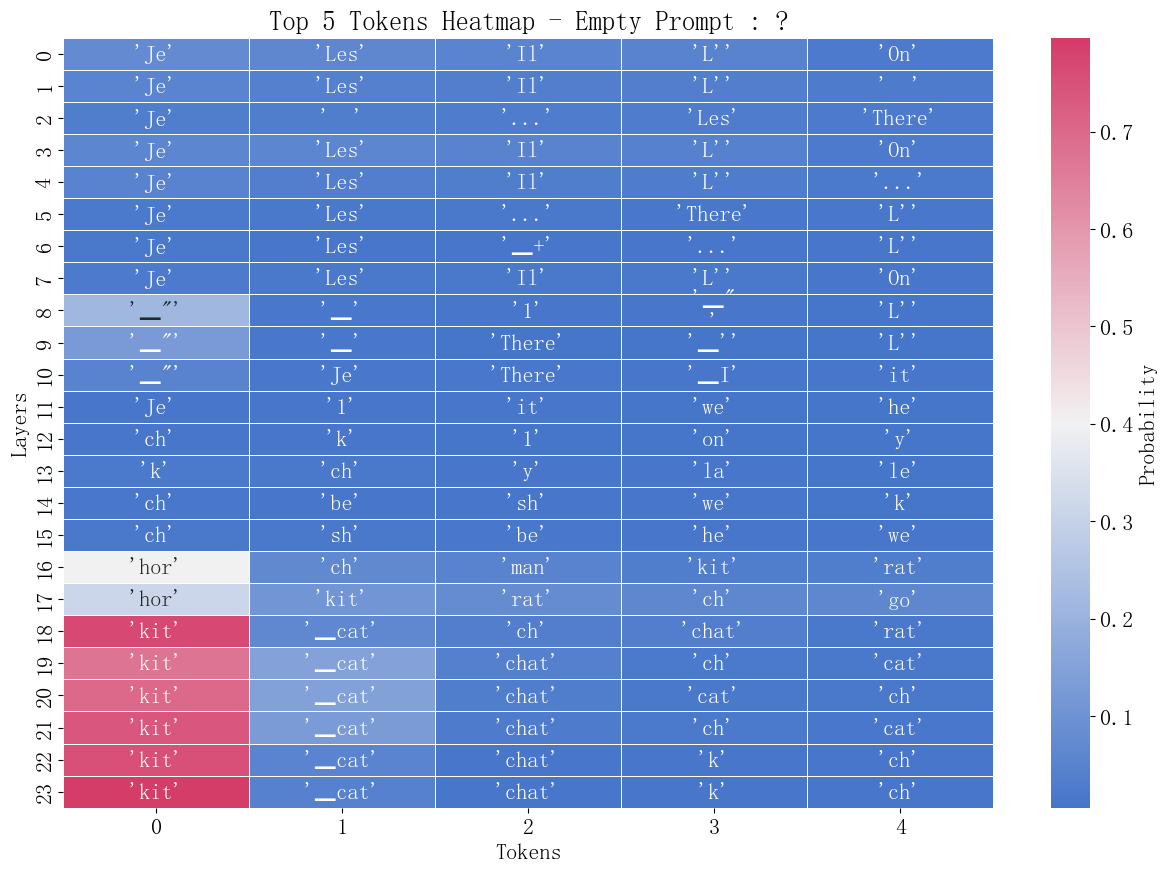

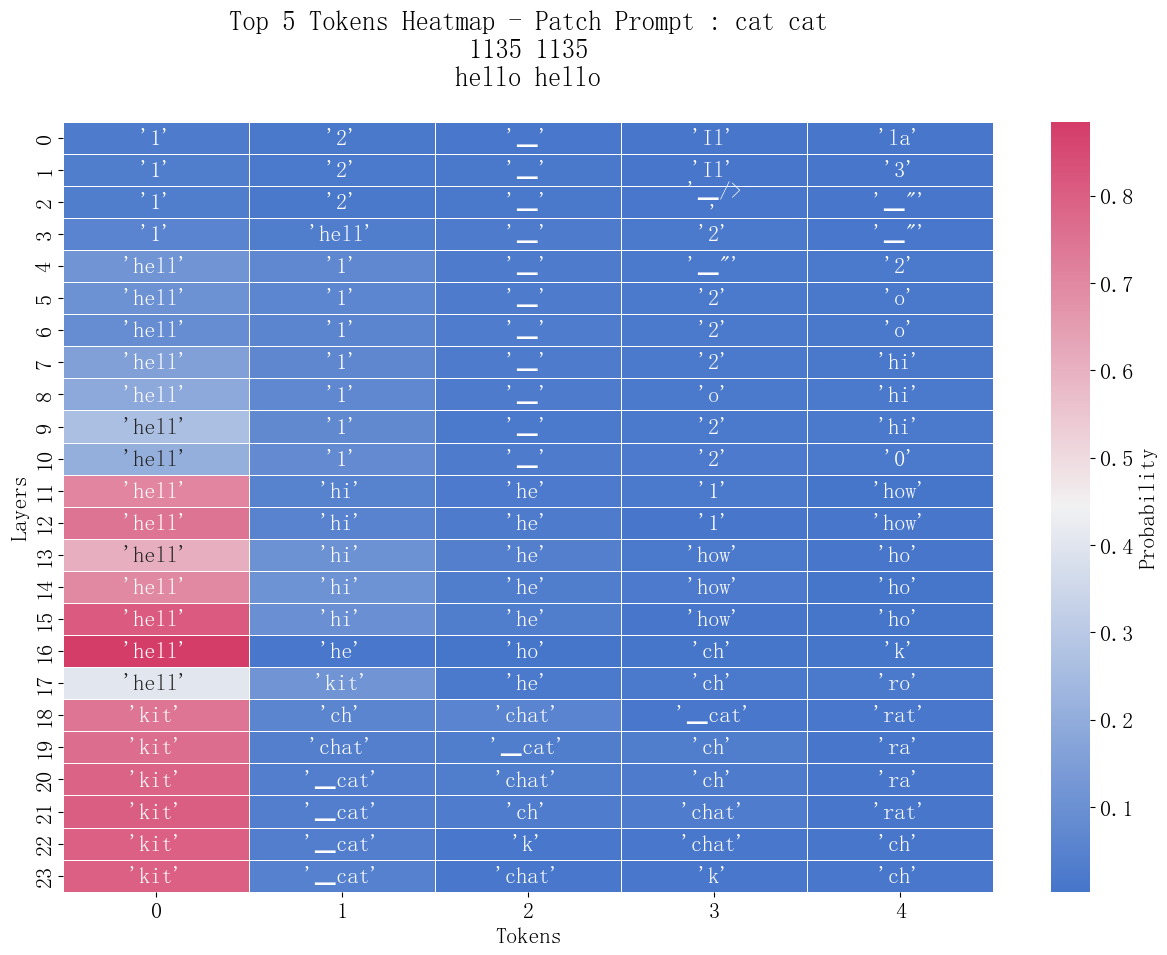

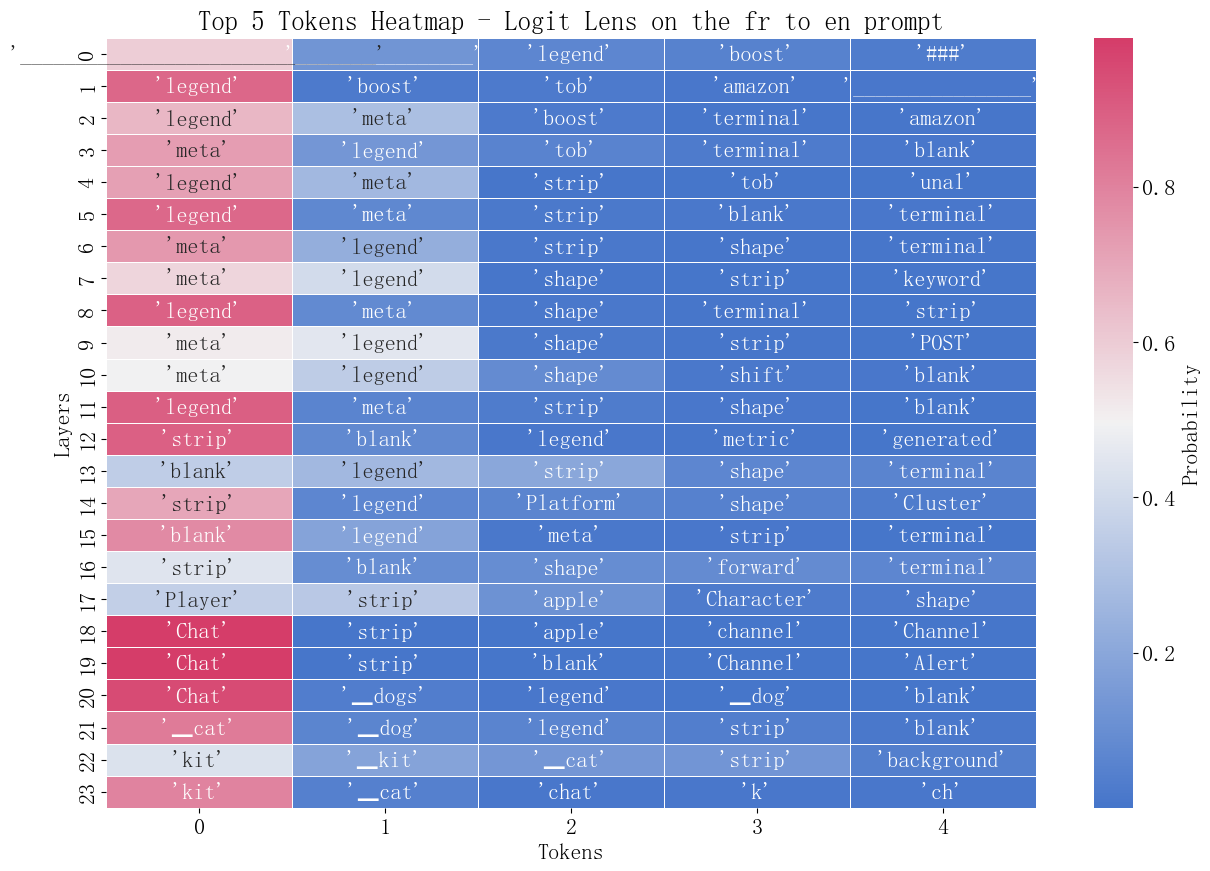

In [31]:
plot_topk(
    empty_probs[0],
    nn_model,
    k=5,
    title=f"Empty Prompt : {empty_prompt.prompt}",
    dynamic_size=0,
)
plot_topk(
    patch_probs[0],
    nn_model,
    k=5,
    title=f"Patch Prompt : {patch_prompt.prompt}",
    dynamic_size=0,
)
plot_topk(
    llens_probs[0],
    nn_model,
    k=5,
    title="Logit Lens on the fr to en prompt",
    dynamic_size=0,
)